#  Поиск каверов композиций для музыкального сервиса

# Краткое описание целей и задач

Для улучшения рекомендательного сервиса разработаем модель, которая сможет обнаруживать все каверы для заданной композиции, после чего их можно будет добавить или исключить из рекомендованных пользователю треков в зависимости от его предпочтений. 

## Введение

In [1]:
import numpy as np
import pandas as pd
import pprint as pp
import random
import seaborn as sns

from catboost import CatBoostClassifier
from cover_finder import CoverFinder
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split

In [2]:
meta_df = pd.read_json('datasets/meta.json', lines=True)

In [3]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track_id  71768 non-null  object 
 1   dttm      71768 non-null  float64
 2   title     71768 non-null  object 
 3   language  21969 non-null  object 
 4   isrc      71455 non-null  object 
 5   genres    71768 non-null  object 
 6   duration  71768 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.8+ MB


В датасете есть информация с названием треков, номером идентификатора ISRC, из которого можно получить год релиза, но нет информации об исполнителе, а значит не будет возможности отличать кавер композиции от его альтернативной версии.

Изначально была проведена попытка собрать дополнительные метаданные с помощью сторонних API, но положительных результатов это не дало.
Например, из 71 тыс. запросов к сервису MusicBrainz по ISRC кодам 68 тыс. вернулись с ошибкой, что данные коды отстуствуют в этой базе.
Аналогичные проблемы наблюдались с сервисами Deezer и Youtube.

Поэтому данная работа была выполнена по имеющимся в наличии данным и не нарушает авторские права и лицензии.

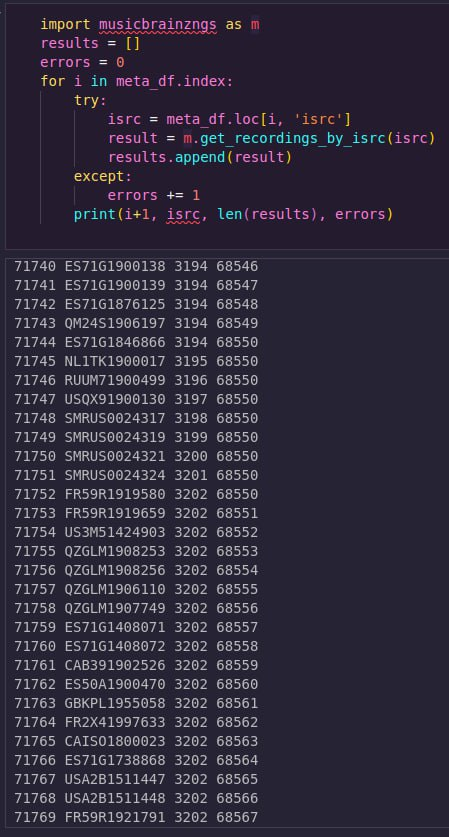

как покал исследовательский анализ метаданных, каверы достаточно точно можно определять просто по схожести треков, что подробно описано в отдельном ноутбуке (no ML solution.ipnb)

## Анализ имеющихся данных

In [4]:
lyrics_df = pd.read_json('datasets/lyrics.json', lines=True)

In [5]:
lyrics_df.head()

,lyricId,text,track_id
0,a951f9504e89759e9d23039b7b17ec14,"Живу сейчас обломами, обломками не той любви\n...",1c4b1230f937e4c548ff732523214dcd
1,0c749bc3f01eb8e6cf986fa14ccfc585,Tell me your fable\nA fable\nTell me your fabl...,0faea89b0d7d6235b5b74def72511bd8
2,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,9c6dc41d5ccd9968d07f055da5d8f741
3,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,bfd04a73e9cffdf0e282c92219a86ea1
4,7624653ca8522ba93470843c74961b7d,"You showed him all the best of you,\nBut I'm a...",8d70930d09cd239c948408d1317d8659


In [6]:
lyrics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB


Данных с текстами песен значительно меньше чем мета данных.

In [7]:
covers_df = pd.read_json('datasets/covers.json', lines=True)

In [8]:
covers_df.head()

,original_track_id,track_id,track_remake_type
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL
1,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL
2,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL
3,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL
4,None,d6288499d0083cc34e60a077b7c4b3e1,COVER


In [9]:
covers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


In [10]:
covers_df.loc[(covers_df['track_remake_type'] == 'COVER') & (covers_df['original_track_id'].notna())]

,original_track_id,track_id,track_remake_type
33,b9213d37c37deffe8b8af0dac5d0c3c4,58a293c4c86b4c0000b0e683c77432a8,COVER
40,deb9b9598176a0bab1212d430b10bd04,bfa9c5c62c08a0db763e2a2284e3d1b2,COVER
51,b9213d37c37deffe8b8af0dac5d0c3c4,79eb48bb4409051aab1602e390c98736,COVER
60,b9213d37c37deffe8b8af0dac5d0c3c4,a106cea5c02ed8a70b421831cc4e7192,COVER
67,b9213d37c37deffe8b8af0dac5d0c3c4,7c9052caed90949c46c171951cd9dc3d,COVER
...,...,...,...
70720,25b8e40b7fa4df88af70590ee44bb820,af95d0aa50dc1934de870c7cc0adafc7,COVER
70721,8eb966d9b7b88b0816b70f7d47a963df,0a89e59f9216b80f5619b4faa8e3753a,COVER
70932,efb09c8e01086753d9ed9119a88d8748,ddcaf83d03b764f17bf3adb35fd93dcf,COVER
71003,a6bea0f1418b5e768b689604e11d111d,4db9bfa70567a07578ad151df3b7f36c,COVER


У нас есть 528 строк с сопоставленными каверами и оригиналами, эти данные можно использовать для обучения модели.

# Целевой признак модели

Разрабатываемая нами модель должна отвечать на вопрос, обладают ли два сравниваемых трека достаточной схожестью (1) или это разные композиции (0). Для признака (1) возьмём строки, где есть соответствие оригинал-кавер, для признака (0) будем сопоставим случайные треки, из не попавших в выборку с признаком (1).

Выберем срез данных, где есть соответствие кавер-оригинал и создадим в нём колонку с признкаом 1.

In [11]:
pd.options.mode.chained_assignment = None

In [12]:
covers_df_1 = covers_df.loc[(covers_df['track_remake_type'] == 'COVER') & (covers_df['original_track_id'].notna())]
covers_df_1['target'] = 1
covers_df_1 = covers_df_1.drop('track_remake_type', axis=1)

covers_df_1.shape

(528, 3)

Соберём id всех треков, попавших в первый срез. 

In [13]:
cover_ids = covers_df_1['track_id'].to_list()

In [14]:
original_ids = covers_df_1['original_track_id'].to_list()

In [15]:
target_1_ids = cover_ids + original_ids

Выберем id всех треков в датасете с текстами и исключим из них те, что уже попали в первый срез.

In [16]:
all_ids = lyrics_df['track_id'].to_list()

In [17]:
target_0_ids = [id for id in all_ids if id not in target_1_ids]

In [18]:
target_0_ids = list(set(target_0_ids))

Перемешаем треки и сопоставим из друг с другом случайным образом.

In [19]:
BATCH = len(target_0_ids) // 2

In [20]:
selected_target_0_ids = random.sample(list(target_0_ids), BATCH * 2)

Сопоставим треки попарно и соберём их в датасет с признаком 0.

In [21]:
covers_df_0 = pd.DataFrame({'original_track_id': selected_target_0_ids[:BATCH], 'track_id': selected_target_0_ids[BATCH:], 'target': np.zeros(BATCH)})

Объединим датасеты с приизнаками 1 и 0 и перемешаем их.

In [22]:
covers_for_model = pd.concat([covers_df_1, covers_df_0], ignore_index=True).sample(frac=1).reset_index(drop=True)

In [23]:
covers_for_model['target'].value_counts()

target
0.0    4872
1.0     528
Name: count, dtype: int64

Целевой признак не сбалансирован, учтём это в дальнейшем.

In [24]:
covers_for_model

,original_track_id,track_id,target
0,5a0364e2ed2e74aca459e86bc43efab9,ec7dc1e8b722f2276f669a27f4c4ec66,0.0
1,4592e00ed69109ea76d20607b0419b68,1884d2d037b9580b56faa419eec6ad1c,0.0
2,2efd3259d8cbb5f7968a389276568c31,3fea4850d6484a723f07f011657c5726,0.0
3,84663cf9ed9f1793d04d7d739e12ba1b,2668f54557dcc46a004f83a8bf6b619e,0.0
4,7982d92699c67adb272493b53c4c08d8,aafe7ec9470b6ba4c79b4858444f91b9,0.0
...,...,...,...
5395,9920a8bdcfd4020eda9c25116690223a,ef208646991a08eaac02bf4088cc735e,0.0
5396,43081a91968cf1d667a1867a578d8dd2,2dc9ae72a53470bb18a020c2fcc1aec2,0.0
5397,5b85a7024058ef25b743117eef2a446a,68e1821d4bc49baee676fef211375825,1.0
5398,6e7b2a877abc4b201fb0e5d7bd4e6fd7,e6e445a0b6b8d631d9de3c75579e145b,0.0


Для данных из этой таблицы мы будем проводить сравнение метаданных, займёмся их преобразованием.

## Преобразование метаданных в параметры модели

Избавимся от не информативных столбцов:

In [25]:
meta_df = meta_df.drop(['dttm', 'language', 'genres'], axis=1)
meta_df

,track_id,title,isrc,duration
0,c3b9d6a354ca008aa4518329aaa21380,Happy New Year,RUB422103970,161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,Bad Habits,QZN882178276,362260.0
2,955f2aafe8717908c140bf122ba4172d,Por Esa Loca Vanidad,QZNJZ2122549,260000.0
3,fae5a077c9956045955dde02143bd8ff,Mil Lagrimas,QZNJZ2166033,190000.0
4,6bede082154d34fc18d9a6744bc95bf5,Sexo Humo y Alcohol,QZNJZ2122551,203000.0
...,...,...,...,...
71764,4be93dea1715e54db86aaa7f7e9bfb10,Chanceuse,CAISO1800023,212690.0
71765,7cba0f30eaa8766d6c203eff2f3750a2,Quiero Que Vuelvas,ES71G1738868,237540.0
71766,26b6aca1c6a02ad0e2a939164716657e,Vacation,USA2B1511447,215210.0
71767,d904dda141238e6ad1b428bfbb21262d,Dance Hall Days,USA2B1511448,251010.0


Избавимся от пропусков в датасете:

In [26]:
meta_df = meta_df.dropna()

Выберем срез значения ISRC, отвечающего за год релиза:

In [27]:
meta_df['isrc'] = meta_df['isrc'].str[5:7]

Избавимся от аномально значения '5-' в столбце ISRC:

In [28]:
meta_df = meta_df[meta_df['isrc'] != '5-']

Преобразуем формат столбца ISRC в числовой, а title в строчный.

In [29]:
meta_df['isrc'] = meta_df['isrc'].astype(int)

In [30]:
meta_df['title'] = meta_df['title'].astype(str)

Преобразуем год релиза в 4х-значное число:

In [31]:
meta_df['isrc'] = np.where(meta_df['isrc'] <= 24, 2000 + meta_df['isrc'], 1900 + meta_df['isrc']) 

Присоединим датафрейм с текстом:

In [32]:
meta_df = lyrics_df.merge(meta_df, how='left', on='track_id').drop('lyricId', axis=1)

Переименуем столбцы:

In [33]:
meta_df = meta_df.rename(columns={'isrc': 'release', 'track_id': 'original_track_id'})

In [34]:
meta_df = meta_df.dropna()

Преобразуем формат столбца с годом релиза в целочисленный.

In [35]:
meta_df['release'] = meta_df['release'].astype(int)

Сохраним полученный датасет для дальнейшого использования обученной моделью:

In [36]:
meta_df.to_csv('datasets/meta_for_model.csv', sep='\t', encoding='utf-8')

Сделаем отдельную копию датасета для треков с каверами:

In [37]:
c_meta_df = meta_df.copy()

Переименуем столбцы в датасете:

In [38]:
c_meta_df = c_meta_df.rename(columns={'original_track_id': 'track_id', 'title': 'cvr_title', 'release': 'cvr_release', 'duration': 'cvr_duration', 'text': 'cvr_text'})

Соединим метаданные сравниваемых треков в один датасет:

In [39]:
covers_meta_df = covers_for_model.merge(meta_df, on='original_track_id', how='inner').merge(c_meta_df, on='track_id', how='inner')

In [40]:
covers_meta_df.shape

(6610, 11)

Посмотрим на распределение признаков в получившемся датасете.

In [41]:
covers_meta_df['target'].value_counts()

target
0.0    5727
1.0     883
Name: count, dtype: int64

Целевые приизнаки не сбалансированы.

Удалим столбцы треков с их id.

In [42]:
covers_meta_df = covers_meta_df.drop(['original_track_id', 'track_id'], axis=1)

## Создание синтетических признаков для модели

Создадим признак с разницей между годами релиза сравниваемых треков и удалим изначальные признаки. 

In [43]:
covers_meta_df['release_diff'] = abs(covers_meta_df['release'] - covers_meta_df['cvr_release'])

In [44]:
covers_meta_df = covers_meta_df.drop(['release', 'cvr_release'], axis=1)

Создадим признак с разницей между длительностями сравниваемых треков и удалим изначальные признаки.

In [45]:
covers_meta_df['duration_diff'] = abs(covers_meta_df['duration'] - covers_meta_df['cvr_duration'])

In [46]:
covers_meta_df = covers_meta_df.drop(['duration', 'cvr_duration'], axis=1)

Для сравнения названий треков будем использовать [Коэффициент Жаккара](https://ru.wikipedia.org/wiki/Коэффициент_Жаккара).
Для совпадающих названий он будет равен 1, для не совпадающих близок к нулю.

In [47]:
def jaccard_similarity_row(row):
  """ returns the jaccard similarity between two lists """
  x = row['title']
  y = row['cvr_title']
  try:
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)
  except:
    return np.nan

Создадим признак с коэффициентом Жаккара и удалим изначалььные признаки.

In [48]:
covers_meta_df['title_diff'] = covers_meta_df[['title', 'cvr_title']].apply(jaccard_similarity_row, axis=1)

In [49]:
covers_meta_df = covers_meta_df.drop(['title', 'cvr_title'], axis=1)

Для сравнения текстов будем использать их векторные представления.
В случае полного совпадения текста признак будет равен 1, т.е. будет показывать  степень совпадения.

In [50]:
#Функция, рассчитывающая расстояние между двумя текстами
def cosine_sim_row(row):
    
    text_1 = row['text']
    text_2 = row['cvr_text']
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform([text_1, text_2])
    return ((tfidf * tfidf.T).A)[0,1]

Создадим признак схожести текста и удалим изначальные параметры и повторы.

In [51]:
covers_meta_df['text_diff'] = covers_meta_df.apply(cosine_sim_row, axis=1)

In [52]:
covers_meta_df = covers_meta_df.drop(['text', 'cvr_text'], axis=1)

In [53]:
covers_meta_df = covers_meta_df.dropna()

## Анализ полученного датасета

Посмотрим на получившийся датасет.

In [54]:
covers_meta_df

,target,release_diff,duration_diff,title_diff,text_diff
0,0.0,1,37880.0,0.181818,0.240173
1,0.0,6,54360.0,0.000000,0.000000
2,0.0,6,54360.0,0.000000,0.000000
3,0.0,0,64770.0,0.363636,0.000000
4,0.0,12,225070.0,0.260870,0.245274
...,...,...,...,...,...
6605,0.0,0,136990.0,0.222222,0.157639
6606,0.0,0,29700.0,0.150000,0.008812
6607,1.0,0,4570.0,1.000000,0.906332
6608,0.0,3,87940.0,0.333333,0.118773


Приведём целевой признак к целочисленному формату.

In [55]:
covers_meta_df['target'] = covers_meta_df['target'].astype(int)

Сохраним датасет для возможности его использвания в других ноутбуках.

In [56]:
covers_meta_df.to_csv('datasets/meta_for_training.csv', sep='\t', encoding='utf-8')

Посмотрим как распределены параметры в датасете.

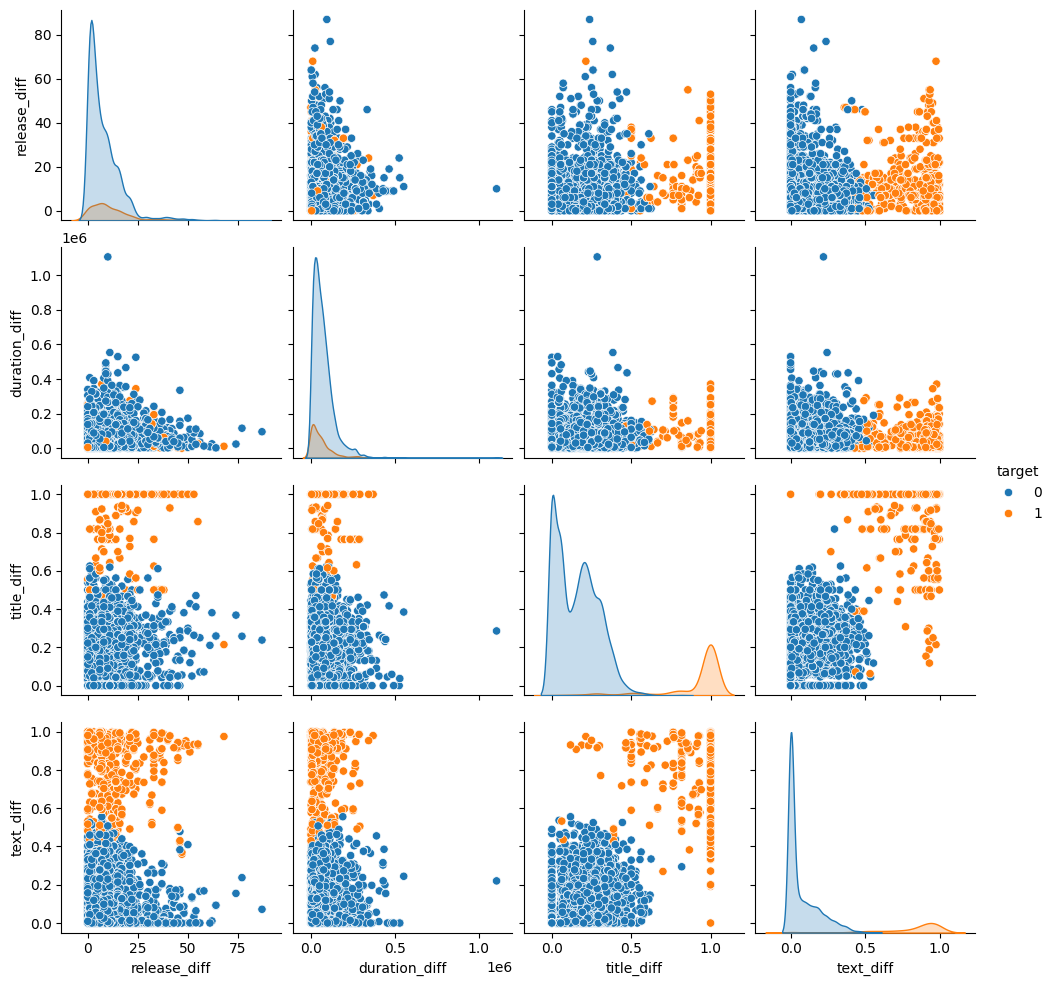

In [57]:
sns.pairplot(covers_meta_df, hue='target')

- разности годов релиза нормально распределены для обоих признаков 
- разности длительности треков также нормально распределены для обоих признаков и почти совпадают
- показатели схожести названий сильно отличаются для признаков, для схожих треков самое частое значение  - 1, т.е. полное совпадений названий.
- показатели различий текстов сильно отличаются для признаков, для разных треков самое частое значение - 0, т.е. тексты не совпадают, но для схожих треков этот показатель достаточно сильно распределён.

## Обучение модели

Разделим датасет на тренировочную и тестовую выборки.

In [58]:
data_train, data_test = train_test_split(covers_meta_df, stratify=covers_meta_df['target'], test_size=0.2)

Из тренировочной выборки дополнительно выделим валидационную для обучения модели.

In [59]:
data_train, data_valid = train_test_split(data_train, stratify=data_train['target'], test_size=0.25)

Разделим выборки на признаки и параметры.

In [60]:
features_train = data_train.drop('target', axis=1)
target_train = data_train['target']

In [61]:
features_valid = data_valid.drop('target', axis=1)
target_valid = data_valid['target']

Сбалансируем целевые признаки в тренировочной выборке.

In [62]:
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='auto'))

features_samp, target_samp = resample.fit_resample(features_train, target_train)

После сэмплирования целевой признак распределён примерно поровну.

In [63]:
model = CatBoostClassifier(verbose=False)

model.fit(features_samp, 
          target_samp,
          #cat_features = cat_features,
          eval_set=(features_valid, target_valid),
          plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [64]:
print(classification_report(target_valid, model.predict(data=features_valid), digits=5))

              precision    recall  f1-score   support

           0    0.99825   0.99913   0.99869      1145
           1    0.99432   0.98870   0.99150       177

    accuracy                        0.99773      1322
   macro avg    0.99629   0.99391   0.99510      1322
weighted avg    0.99773   0.99773   0.99773      1322



Бэйслайн модель классификации показывает очень точные результаты, обнаруживает схожие треки в 99% случаев, возможно эти результаты улучшить с помощью оптимизации гиперпараметров.

Оценим важность влияния параметров на целевой признак.

In [65]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,text_diff,30.074105
1,title_diff,29.043641
2,duration_diff,26.912807
3,release_diff,13.969448


Все параметры обладают достаточной степенью важности, сохраним модель.

In [66]:
model.save_model("models/cvr_clsfr_mdl.cbm")

Обучим и сохраним ещё одну модель с параметрами, полученными при оптимизации.

In [67]:
model_1 = CatBoostClassifier(
    iterations=1758,
    learning_rate=0.04120428861906423,
    depth=10,
    l2_leaf_reg=0.01888103986880093,
    bootstrap_type='Bayesian',
    random_strength=4.848702461343636,
    bagging_temperature=2.5853849579969137,
    od_type='IncToDec',
    od_wait=11,
    verbose=False)

model_1.fit(features_samp, 
          target_samp,
          #cat_features = cat_features,
          eval_set=(features_valid, target_valid),
          plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [68]:
print(classification_report(target_valid, model_1.predict(data=features_valid), digits=5))

              precision    recall  f1-score   support

           0    0.99738   0.99913   0.99825      1145
           1    0.99429   0.98305   0.98864       177

    accuracy                        0.99697      1322
   macro avg    0.99584   0.99109   0.99345      1322
weighted avg    0.99697   0.99697   0.99697      1322



Модель показывает результаты схожие с бэйслайн моделью, сохраним эту модель.

In [69]:
model_1.save_model("models/cvr_clsfr_mdl_1.cbm")

**Поиск оптимальных гиперпараметров модели и оценка метрики на тестовой выборке приведены в отдельной тетради (model_optimisation.ipynb).**

## Тестирование моделей

Для тестирования модели создадим класс CoverFinder, который будет получать на вход id трека из базы, определять схожие треки и формировать список каверов. По умолчанию класс обучает модель заданными параметрами и пользуется изначальным датасет, но может получать на вход дополнительные параметры с указанием пути к модели и метаданным. 

### Тестирование бэйслайн модели

Для примера передадим id трека "deb9b9598176a0bab1212d430b10bd04" для объекта с бэйслайн моделью. 

In [70]:
finder = CoverFinder('datasets/meta_for_model.csv', 'models/cvr_clsfr_mdl.cbm')
finder.search_covers('deb9b9598176a0bab1212d430b10bd04')
pp.pprint(finder.show_covers())
pp.pprint(finder.show_cover_number())
pp.pprint(finder.show_original())


tracks fetched
[{'id': 'fc6f9ddb70e2a6035bc0d49afc821ce6',
  'release_year': 2022,
  'title': 'Riders on the Storm'},
 {'id': '749323aed3c585998d21db17eb3ceb3a',
  'release_year': 2020,
  'title': 'Sweet Dreams (Are Made of This)'},
 {'id': 'ce39354dbe4fbfb2c8cf605fb177be5e',
  'release_year': 1999,
  'title': 'Sweet Dreams/ Hell Outro'},
 {'id': 'f66a59e4931cde981b70a3ae144fb7fb',
  'release_year': 2016,
  'title': 'Sweet Dreams'},
 {'id': 'e0f8c51fb892ca24fc42c7db59e152ac',
  'release_year': 2021,
  'title': 'Silky Heart (From "Toradora!")'},
 {'id': '091d038bb1f4b60a0982a8f05bb59309',
  'release_year': 2021,
  'title': 'Sora to Utsuro (From "The Case Study of Vanitas")'},
 {'id': '0d48e3683a1a0c0d3cec604fbf58fb35',
  'release_year': 2016,
  'title': 'Sweet Dreams (Are Made of This) [From "X-Men: Apocalypse"]'},
 {'id': '4968f3f3cedda92f1063eba4764e083a',
  'release_year': 2019,
  'title': 'Sweet Dreams (Are Made of This)'},
 {'id': '5abc80144883057a76ea578fba6b0eef',
  'release_year

Объект приавильно распознал, что это оригинальный трек и показал список из 47 каверов, среди которых большая часть реальные каверы, но есть и посторонние треки.

Передадим объекту id трека "749323aed3c585998d21db17eb3ceb3a", являющегося кавером композиции выше.

In [71]:
finder = CoverFinder('datasets/meta_for_model.csv', 'models/cvr_clsfr_mdl.cbm')
finder.search_covers('749323aed3c585998d21db17eb3ceb3a')
pp.pprint(finder.show_covers())
pp.pprint(finder.show_cover_number())
pp.pprint(finder.show_original())

tracks fetched
[{'id': '749323aed3c585998d21db17eb3ceb3a',
  'release_year': 2020,
  'title': 'Sweet Dreams (Are Made of This)'},
 {'id': 'ce39354dbe4fbfb2c8cf605fb177be5e',
  'release_year': 1999,
  'title': 'Sweet Dreams/ Hell Outro'},
 {'id': 'f66a59e4931cde981b70a3ae144fb7fb',
  'release_year': 2016,
  'title': 'Sweet Dreams'},
 {'id': '5d58239c397f8a7b93e7c642d9d9b2b5',
  'release_year': 2023,
  'title': 'Give It To Me'},
 {'id': 'f548e19d18251f697e7dfca56e7bbd1c',
  'release_year': 2020,
  'title': 'Possessed To The Circle Pit'},
 {'id': '0d48e3683a1a0c0d3cec604fbf58fb35',
  'release_year': 2016,
  'title': 'Sweet Dreams (Are Made of This) [From "X-Men: Apocalypse"]'},
 {'id': '4968f3f3cedda92f1063eba4764e083a',
  'release_year': 2019,
  'title': 'Sweet Dreams (Are Made of This)'},
 {'id': '5abc80144883057a76ea578fba6b0eef',
  'release_year': 2020,
  'title': 'Sweet Dreams'},
 {'id': 'deb9b9598176a0bab1212d430b10bd04',
  'release_year': 1983,
  'title': 'Sweet Dreams (Are Made of

Объект не распознал оригинал трека и выдал список из 37 похожих треков.

Повторим те же действия для других обученных моделей.

### Тестирование улучшенной модели.

In [72]:
finder = CoverFinder('datasets/meta_for_model.csv', 'models/cvr_clsfr_mdl_1.cbm')
finder.search_covers('deb9b9598176a0bab1212d430b10bd04')
pp.pprint(finder.show_covers())
pp.pprint(finder.show_cover_number())
pp.pprint(finder.show_original())

tracks fetched
[{'id': '749323aed3c585998d21db17eb3ceb3a',
  'release_year': 2020,
  'title': 'Sweet Dreams (Are Made of This)'},
 {'id': 'ce39354dbe4fbfb2c8cf605fb177be5e',
  'release_year': 1999,
  'title': 'Sweet Dreams/ Hell Outro'},
 {'id': 'f66a59e4931cde981b70a3ae144fb7fb',
  'release_year': 2016,
  'title': 'Sweet Dreams'},
 {'id': '091d038bb1f4b60a0982a8f05bb59309',
  'release_year': 2021,
  'title': 'Sora to Utsuro (From "The Case Study of Vanitas")'},
 {'id': '0d48e3683a1a0c0d3cec604fbf58fb35',
  'release_year': 2016,
  'title': 'Sweet Dreams (Are Made of This) [From "X-Men: Apocalypse"]'},
 {'id': '4968f3f3cedda92f1063eba4764e083a',
  'release_year': 2019,
  'title': 'Sweet Dreams (Are Made of This)'},
 {'id': '5abc80144883057a76ea578fba6b0eef',
  'release_year': 2020,
  'title': 'Sweet Dreams'},
 {'id': 'e4b8f916c81092e5372d4f97a4f3346b',
  'release_year': 2021,
  'title': 'Direito de Amar'},
 {'id': 'ec4b5e5cf7ed20750605ed028f726c64',
  'release_year': 2021,
  'title': 'M

Оригинал распознан, 31 кавер.

In [73]:
finder = CoverFinder('datasets/meta_for_model.csv', 'models/cvr_clsfr_mdl_1.cbm')
finder.search_covers('749323aed3c585998d21db17eb3ceb3a')
pp.pprint(finder.show_covers())
pp.pprint(finder.show_cover_number())
pp.pprint(finder.show_original())


tracks fetched
[{'id': '749323aed3c585998d21db17eb3ceb3a',
  'release_year': 2020,
  'title': 'Sweet Dreams (Are Made of This)'},
 {'id': 'ce39354dbe4fbfb2c8cf605fb177be5e',
  'release_year': 1999,
  'title': 'Sweet Dreams/ Hell Outro'},
 {'id': 'f66a59e4931cde981b70a3ae144fb7fb',
  'release_year': 2016,
  'title': 'Sweet Dreams'},
 {'id': '0d48e3683a1a0c0d3cec604fbf58fb35',
  'release_year': 2016,
  'title': 'Sweet Dreams (Are Made of This) [From "X-Men: Apocalypse"]'},
 {'id': '4968f3f3cedda92f1063eba4764e083a',
  'release_year': 2019,
  'title': 'Sweet Dreams (Are Made of This)'},
 {'id': '5abc80144883057a76ea578fba6b0eef',
  'release_year': 2020,
  'title': 'Sweet Dreams'},
 {'id': '08a52b88aa5ffca6b41b58c6d5ec7a52',
  'release_year': 2019,
  'title': 'Sweet Dreams'},
 {'id': 'f8fb3c76c159efb0033c3b48e0c2a045',
  'release_year': 2021,
  'title': 'Sweet Dreams'},
 {'id': '8f36faa55a52681c41a6cfa1ff1176f0',
  'release_year': 2017,
  'title': 'Sweet Dreams'},
 {'id': 'e1cf3c4ba848dee2

Оригинал распознан, 30 каверов.

### Тестироввание модели с максимальными метриками

In [74]:
finder = CoverFinder('datasets/meta_for_model.csv', 'models/cvr_clsfr_mdl_tuned_100.cbm')
finder.search_covers('deb9b9598176a0bab1212d430b10bd04')
pp.pprint(finder.show_covers())
pp.pprint(finder.show_cover_number())
pp.pprint(finder.show_original())

tracks fetched
[{'id': 'deb9b9598176a0bab1212d430b10bd04',
  'release_year': 1983,
  'title': 'Sweet Dreams (Are Made of This)'},
 {'id': '749323aed3c585998d21db17eb3ceb3a',
  'release_year': 2020,
  'title': 'Sweet Dreams (Are Made of This)'},
 {'id': '0a2a1b3bdc53ae9ab0c2f601b098c68d',
  'release_year': 1999,
  'title': 'The Man Who Sold The World'},
 {'id': 'c182aee13c192a45593862320a0a9a85',
  'release_year': 2010,
  'title': 'Shadow of the Day (2008)'},
 {'id': 'ce39354dbe4fbfb2c8cf605fb177be5e',
  'release_year': 1999,
  'title': 'Sweet Dreams/ Hell Outro'},
 {'id': 'f66a59e4931cde981b70a3ae144fb7fb',
  'release_year': 2016,
  'title': 'Sweet Dreams'},
 {'id': '1b85a3864ddf4781b437b41e2023befa',
  'release_year': 2010,
  'title': 'Talking to the Moon'},
 {'id': '0092dbc4cfbc01c0c6b0bfc8c0ac6648',
  'release_year': 2017,
  'title': 'Refrain (From "A Love To Last")'},
 {'id': '0a9c07ad9f499a63a8cb824ecdc2d7fa',
  'release_year': 2014,
  'title': 'Counting Stars / The Monster (feat.

Модель с максимальными метриками выдает избыточное количество треков (64) при передача оригинала на ввод и не распознаёт оригинал.

In [75]:
finder = CoverFinder('datasets/meta_for_model.csv', 'models/cvr_clsfr_mdl_tuned_100.cbm')
finder.search_covers('749323aed3c585998d21db17eb3ceb3a')
pp.pprint(finder.show_covers())
pp.pprint(finder.show_cover_number())
pp.pprint(finder.show_original())

tracks fetched
[{'id': '749323aed3c585998d21db17eb3ceb3a',
  'release_year': 2020,
  'title': 'Sweet Dreams (Are Made of This)'},
 {'id': '38694f77422f7c36142f7142a391d696',
  'release_year': 2002,
  'title': 'Hotel California'},
 {'id': '0e5132dac87bf6616b4dc2c5e4ff1c9c',
  'release_year': 2016,
  'title': 'Moon Rider'},
 {'id': 'ce39354dbe4fbfb2c8cf605fb177be5e',
  'release_year': 1999,
  'title': 'Sweet Dreams/ Hell Outro'},
 {'id': 'f66a59e4931cde981b70a3ae144fb7fb',
  'release_year': 2016,
  'title': 'Sweet Dreams'},
 {'id': '73735c7c2c38b8db56fe36a038c2ec2d',
  'release_year': 2017,
  'title': 'Party Monster'},
 {'id': 'f0f429d03fdd19f08ff60e889e32aae2',
  'release_year': 2007,
  'title': 'Let Me Think About It'},
 {'id': '0d48e3683a1a0c0d3cec604fbf58fb35',
  'release_year': 2016,
  'title': 'Sweet Dreams (Are Made of This) [From "X-Men: Apocalypse"]'},
 {'id': '4968f3f3cedda92f1063eba4764e083a',
  'release_year': 2019,
  'title': 'Sweet Dreams (Are Made of This)'},
 {'id': 'e7f8

Модель с максимальными метриками выдает меньшее количество лишних треков (51), но также не находит оригинал.

### Проверка обученной по скрипту библиотеки

In [76]:
finder = CoverFinder()
finder.search_covers('749323aed3c585998d21db17eb3ceb3a')
pp.pprint(finder.show_covers())
pp.pprint(finder.show_cover_number())
pp.pprint(finder.show_original())

tracks fetched
[{'id': '749323aed3c585998d21db17eb3ceb3a',
  'release_year': 2020,
  'title': 'Sweet Dreams (Are Made of This)'},
 {'id': 'ce39354dbe4fbfb2c8cf605fb177be5e',
  'release_year': 1999,
  'title': 'Sweet Dreams/ Hell Outro'},
 {'id': 'f66a59e4931cde981b70a3ae144fb7fb',
  'release_year': 2016,
  'title': 'Sweet Dreams'},
 {'id': '0d48e3683a1a0c0d3cec604fbf58fb35',
  'release_year': 2016,
  'title': 'Sweet Dreams (Are Made of This) [From "X-Men: Apocalypse"]'},
 {'id': '4968f3f3cedda92f1063eba4764e083a',
  'release_year': 2019,
  'title': 'Sweet Dreams (Are Made of This)'},
 {'id': '5abc80144883057a76ea578fba6b0eef',
  'release_year': 2020,
  'title': 'Sweet Dreams'},
 {'id': '08a52b88aa5ffca6b41b58c6d5ec7a52',
  'release_year': 2019,
  'title': 'Sweet Dreams'},
 {'id': 'd6f6d383ad031e1c84ce7bdbc082e4d3',
  'release_year': 2010,
  'title': 'Magic Moments'},
 {'id': 'f8fb3c76c159efb0033c3b48e0c2a045',
  'release_year': 2021,
  'title': 'Sweet Dreams'},
 {'id': '8f36faa55a52681

Оригинал распознан, 25 каверов.

In [77]:
finder.search_covers('deb9b9598176a0bab1212d430b10bd04')
pp.pprint(finder.show_covers())
pp.pprint(finder.show_cover_number())
pp.pprint(finder.show_original())

tracks fetched
[{'id': '749323aed3c585998d21db17eb3ceb3a',
  'release_year': 2020,
  'title': 'Sweet Dreams (Are Made of This)'},
 {'id': 'ce39354dbe4fbfb2c8cf605fb177be5e',
  'release_year': 1999,
  'title': 'Sweet Dreams/ Hell Outro'},
 {'id': 'f66a59e4931cde981b70a3ae144fb7fb',
  'release_year': 2016,
  'title': 'Sweet Dreams'},
 {'id': '091d038bb1f4b60a0982a8f05bb59309',
  'release_year': 2021,
  'title': 'Sora to Utsuro (From "The Case Study of Vanitas")'},
 {'id': '0d48e3683a1a0c0d3cec604fbf58fb35',
  'release_year': 2016,
  'title': 'Sweet Dreams (Are Made of This) [From "X-Men: Apocalypse"]'},
 {'id': '4968f3f3cedda92f1063eba4764e083a',
  'release_year': 2019,
  'title': 'Sweet Dreams (Are Made of This)'},
 {'id': '5abc80144883057a76ea578fba6b0eef',
  'release_year': 2020,
  'title': 'Sweet Dreams'},
 {'id': 'ec4b5e5cf7ed20750605ed028f726c64',
  'release_year': 2021,
  'title': 'Most of the Time'},
 {'id': '08a52b88aa5ffca6b41b58c6d5ec7a52',
  'release_year': 2019,
  'title': '

Оригинал распознан, 31 кавер.

### Выводы по проведённому тестированию

Для рассмотренного случая наиболее адекватные результаты показывает модель с улучшенными характеристиками (также используется для оучения по скриипту).

## Выводы по проделанной работе

- был проведён анализ полученных данных и неудачная попытка дополнить данные с помощью парсинга
- имеющиеся данные были объединены в один датасет, в котором были сформированы признаки для обучения модели
- была обучено несколько моделей классификации, выявляющих схожие треки
- был создан объект, принимающий на вход id трека и выдающий похожие треки
- было проведено тестирование моделей на выбранных треках

## Идеи по дальнейшему улучшению проекта

1. Желательно дополнить имеющиесяя метаданные, хотя бы именем артиста, чтобы среди схожих треков выявлять каверы других исполнителей и альтернативные версии тех же исполнителей.
1. Модели показывают хорошие метрики, но при получении большого количества прогнозов неизбежно появление ошибок, поэтому нужно попробовать делать прогнозы по ограниченному срезу с датасета, например по языку или другим метаданным.
1. Необходимо провести тестирование моделей при разных порогах классификации, возможно это позволит улучшить результаты.
1. Необходимо собрать информацию по трекам ошибочно попадающим в списки каверов и пронализировать почему модель даёт такой прогноз.